# Test 6-Month Washout Window

This notebook tests the 6-month washout window implementation on a small subset of data.


In [1]:
import sys
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/pythonscripts')

from apply_6month_washout import (
    load_bd_censor_from_csv,
    load_enrollment_ages,
    get_person_ids_from_csv,
    get_order_from_sparse_array,
    apply_washout_to_E
)
import pandas as pd
import torch
import numpy as np

# Try to import pyreadr
try:
    import pyreadr
    HAS_PYREADR = True
except ImportError:
    HAS_PYREADR = False
    print("Note: pyreadr not available. Install with: pip install pyreadr")
    print("      Or use rpy2 to read RDS files.")

# Try to import rpy2
try:
    import rpy2.robjects as robjects
    import scipy.sparse as sp
    HAS_RPY2 = True
except ImportError:
    HAS_RPY2 = False
    print("Note: rpy2 not available. Install with: pip install rpy2")
    print("      Needed to read sparse_array.rds for disease_codes order.")


In [7]:
# Load bd.censor (enrollment dates)
print("Loading bd.censor...")
bd_censor_df = load_bd_censor_from_csv(
    "~/Library/CloudStorage/Dropbox-Personal/bd_censor.csv"
)
print(f"Loaded {len(bd_censor_df):,} patients")
print(f"Columns: {bd_censor_df.columns.tolist()}")
print(f"\nFirst few rows:")
bd_censor_df.head()


Loading bd.censor...
Loaded 502,461 patients
Columns: ['f.eid', 'enroll_date', 'phenotype_censor_date', 'death_censor_date', 'birthdate']

First few rows:


,f.eid,enroll_date,phenotype_censor_date,death_censor_date,birthdate
0,1000015.0,2008-07-23,2022-10-31,2022-11-30,1938-12-15
1,1000023.0,2008-09-11,2022-10-31,2022-11-30,1963-09-15
2,1000037.0,2009-01-22,2022-10-31,2022-11-30,1939-11-15
3,1000042.0,2009-11-13,2022-10-31,2022-11-30,1942-12-15
4,1000059.0,2009-05-20,2022-10-31,2022-11-30,1954-12-15


In [8]:
# Load enrollment ages
print("Loading enrollment ages...")
enrollment_ages = load_enrollment_ages(
    "~/Library/CloudStorage/Dropbox-Personal/data_for_running/baselinagefamh.csv"
)
print(f"Loaded enrollment ages for {len(enrollment_ages):,} patients")


Loading enrollment ages...
Loading enrollment ages from ~/Library/CloudStorage/Dropbox-Personal/data_for_running/baselinagefamh.csv...
Loaded enrollment ages for 407,878 patients
Loaded enrollment ages for 407,878 patients


In [2]:
# Load HESIN data with dates (the 'd' dataframe)
print("Loading HESIN data with dates...")
if HAS_PYREADR:
    hesin_result = pyreadr.read_r(
        "~/Library/CloudStorage/Dropbox-Personal/hesin_with_dates.rds"
    )
    hesin_df = list(hesin_result.values())[0]
else:
    # Fallback: try rpy2
    if HAS_RPY2:
        hesin_r = robjects.r.readRDS("~/Library/CloudStorage/Dropbox-Personal/hesin_with_dates.rds")
        hesin_df = pd.DataFrame(hesin_r)
    else:
        raise ImportError("Need pyreadr or rpy2 to read RDS files")

print(f"Loaded {len(hesin_df):,} HESIN events")
print(f"Columns: {hesin_df.columns.tolist()}")
print(f"\nFirst few rows:")
hesin_df.head()


Loading HESIN data with dates...
Loaded 12,446,932 HESIN events
Columns: ['f.eid', 'birthdate', 'event_start', 'ins_index', 'arr_index', 'level', 'vocabulary_id', 'code', 'code_char', 'age']

First few rows:


,f.eid,birthdate,event_start,ins_index,arr_index,level,vocabulary_id,code,code_char,age
0,1000015.0,1938-12-15,2020-06-27,1,1,2,ICD10CM,R91,3,81.5
1,1000015.0,1938-12-15,2020-06-27,1,5,2,ICD10CM,E780,4,81.5
2,1000015.0,1938-12-15,2020-06-27,1,4,2,ICD10CM,M199,4,81.5
3,1000015.0,1938-12-15,2020-06-27,1,0,1,ICD10CM,R073,4,81.5
4,1000015.0,1938-12-15,2020-06-27,1,6,2,ICD10CM,N40,3,81.5


In [3]:
# Load icdlab (Phecode mappings)
print("Loading icdlab (Phecode mappings)...")
if HAS_PYREADR:
    icdlab_result = pyreadr.read_r(
        "~/Library/CloudStorage/Dropbox-Personal/hesin_phecoded.rds"
    )
    icdlab_df = list(icdlab_result.values())[0]
else:
    if HAS_RPY2:
        icdlab_r = robjects.r.readRDS("~/Library/CloudStorage/Dropbox-Personal/hesin_phecoded.rds")
        icdlab_df = pd.DataFrame(icdlab_r)
    else:
        raise ImportError("Need pyreadr or rpy2 to read RDS files")

print(f"Loaded {len(icdlab_df):,} Phecode-mapped events")
print(f"Columns: {icdlab_df.columns.tolist()}")
print(f"\nFirst few rows:")
icdlab_df.head()


Loading icdlab (Phecode mappings)...
Loaded 3,326,204 Phecode-mapped events
Columns: ['eid', 'diag_icd10', 'age_diag']

First few rows:


,eid,diag_icd10,age_diag
0,1000015.0,272.11,82.0
1,1000015.0,495.00,74.0
2,1000015.0,496.00,82.0
3,1000015.0,600.00,82.0
4,1000015.0,716.90,82.0


In [9]:
# Get person_ids order (from processed_ids.csv or sparse_array.rds)
print("Loading person_ids order...")
try:
    # Try from sparse_array.rds first (source of truth)
    person_ids, disease_codes = get_order_from_sparse_array(
        "~/Downloads/sparse_array.rds"
    )
    print(f"Loaded from sparse_array.rds: {len(person_ids):,} person_ids, {len(disease_codes):,} disease_codes")
except Exception as e:
    print(f"Could not load from sparse_array.rds: {e}")
    # Fallback to processed_ids.csv
    person_ids = get_person_ids_from_csv(
        "~/aladynoulli2/pyScripts/csv/processed_ids.csv"
    )
    print(f"Loaded from processed_ids.csv: {len(person_ids):,} person_ids")
    # For disease_codes, you'll need to load from R or provide manually
    disease_codes = []  # You need to provide this
    print("WARNING: disease_codes not loaded. You need to provide this!")

# Create disease mapping
disease_mapping = {code: idx for idx, code in enumerate(disease_codes)}
print(f"\nDisease mapping created: {len(disease_mapping):,} diseases")


Loading person_ids order...
Loading sparse_array.rds to extract person_ids and disease_codes order...
Extracted 407,878 person_ids and 348 disease_codes
Loaded from sparse_array.rds: 407,878 person_ids, 348 disease_codes

Disease mapping created: 348 diseases


In [10]:
# Load E matrix
E_path = "/Users/sarahurbut/Dropbox-Personal/data_for_running/E_enrollment_full.pt"  # Update this path
print(f"Loading E matrix from {E_path}...")
E_original = torch.load(E_path, map_location='cpu', weights_only=False)
print(f"E matrix shape: {E_original.shape}")
print(f"E matrix dtype: {E_original.dtype}")

# For testing, use first 10K patients
TEST_N = 10000
if E_original.shape[0] > TEST_N:
    print(f"\nTesting on first {TEST_N:,} patients...")
    E_test = E_original[:TEST_N, :].clone()
    eid_order_test = person_ids[:TEST_N]
else:
    E_test = E_original.clone()
    eid_order_test = person_ids

print(f"Test E matrix shape: {E_test.shape}")
print(f"Test eid_order length: {len(eid_order_test):,}")


Loading E matrix from /Users/sarahurbut/Dropbox-Personal/data_for_running/E_enrollment_full.pt...
E matrix shape: torch.Size([407878, 348])
E matrix dtype: torch.int64

Testing on first 10,000 patients...
Test E matrix shape: torch.Size([10000, 348])
Test eid_order length: 10,000


In [11]:
# Filter hesin_df to test patients
hesin_test = hesin_df[hesin_df['f.eid'].isin(eid_order_test)].copy()
print(f"HESIN events for test patients: {len(hesin_test):,}")

# Filter icdlab_df to test patients
icdlab_test = icdlab_df[icdlab_df['eid'].isin(eid_order_test)].copy()
print(f"Phecode-mapped events for test patients: {len(icdlab_test):,}")

# Filter bd_censor to test patients
bd_censor_test = bd_censor_df[bd_censor_df['f.eid'].isin(eid_order_test)].copy()
print(f"bd.censor entries for test patients: {len(bd_censor_test):,}")


HESIN events for test patients: 282,825
Phecode-mapped events for test patients: 80,114
bd.censor entries for test patients: 10,000


In [12]:
# Apply 6-month washout
print("Applying 6-month washout window...")
E_washout, hesin_annotated = apply_washout_to_E(
    hesin_df=hesin_test,
    icdlab_df=icdlab_test,
    bd_censor_df=bd_censor_test,
    enrollment_ages_dict=enrollment_ages,
    E_original=E_test,
    eid_order=eid_order_test,
    disease_mapping=disease_mapping,
    washout_months=6,
    min_age=30
)

print("\nWashout applied successfully!")


Applying 6-month washout window...
APPLYING 6-MONTH WASHOUT WINDOW
Mapping 10,000 patients to E matrix rows

Preparing HESIN data...
Joining with bd.censor for enrollment dates...
Mapping ICD codes to Phecodes...
After Phecode mapping: 796,550 events with valid Phecodes
Found 6,309 / 796,550 events (0.79%) in washout window

Censoring events in washout window...

Censored 6,309 events in E matrix
Skipped 0 events (patient not in E matrix, missing data, or no disease mapping)

Washout applied successfully!


## Diagnostic: Check Data Before Washout


In [13]:
# Diagnostic: Check the data before applying washout
print("="*80)
print("DIAGNOSTIC: CHECKING DATA BEFORE WASHOUT")
print("="*80)

# Check hesin_test
print(f"\nHESIN test data:")
print(f"  Total events: {len(hesin_test):,}")
print(f"  Events with enrollment dates: {hesin_test['f.eid'].isin(bd_censor_test['f.eid']).sum():,}")
print(f"  Sample columns: {hesin_test.columns.tolist()[:10]}")

# Check icdlab_test
print(f"\nPhecode-mapped data:")
print(f"  Total events: {len(icdlab_test):,}")
print(f"  Sample columns: {icdlab_test.columns.tolist()}")

# Check bd_censor_test
print(f"\nEnrollment dates:")
print(f"  Total patients: {len(bd_censor_test):,}")
print(f"  Patients with enrollment dates: {bd_censor_test['enroll_date'].notna().sum():,}")

# Check enrollment ages
enrollment_ages_test = {k: v for k, v in enrollment_ages.items() if k in eid_order_test}
print(f"\nEnrollment ages:")
print(f"  Ages loaded for test patients: {len(enrollment_ages_test):,}")

# Check disease mapping
print(f"\nDisease mapping:")
print(f"  Total diseases: {len(disease_mapping):,}")
print(f"  Sample diseases: {list(disease_mapping.keys())[:10]}")


DIAGNOSTIC: CHECKING DATA BEFORE WASHOUT

HESIN test data:
  Total events: 282,825
  Events with enrollment dates: 282,825
  Sample columns: ['f.eid', 'birthdate', 'event_start', 'ins_index', 'arr_index', 'level', 'vocabulary_id', 'code', 'code_char', 'age']

Phecode-mapped data:
  Total events: 80,114
  Sample columns: ['eid', 'diag_icd10', 'age_diag']

Enrollment dates:
  Total patients: 10,000
  Patients with enrollment dates: 10,000

Enrollment ages:
  Ages loaded for test patients: 10,000

Disease mapping:
  Total diseases: 348
  Sample diseases: ['8.5', '8.6', '38.1', '41', '41.1', '41.2', '41.4', '78', '79', '112']


In [14]:
# Diagnostic: Manually check the join process
print("="*80)
print("DIAGNOSTIC: CHECKING JOIN PROCESS")
print("="*80)

# Simulate the join process
hesin_sample = hesin_test.head(1000).copy()
hesin_sample['event_start'] = pd.to_datetime(hesin_sample['event_start'])

# Join with bd.censor
hesin_sample = hesin_sample.merge(
    bd_censor_test[['f.eid', 'enroll_date', 'birthdate']],
    on='f.eid',
    how='left'
)

print(f"\nAfter joining with bd.censor:")
print(f"  Events with enroll_date: {hesin_sample['enroll_date'].notna().sum():,} / {len(hesin_sample):,}")
print(f"  Sample enroll_date values: {hesin_sample['enroll_date'].head()}")

# Calculate days from enrollment
hesin_sample['days_from_enroll'] = (hesin_sample['event_start'] - hesin_sample['enroll_date']).dt.days

print(f"\nDays from enrollment:")
print(f"  Events with valid days_from_enroll: {hesin_sample['days_from_enroll'].notna().sum():,}")
print(f"  Min days: {hesin_sample['days_from_enroll'].min():.1f}")
print(f"  Max days: {hesin_sample['days_from_enroll'].max():.1f}")
print(f"  Mean days: {hesin_sample['days_from_enroll'].mean():.1f}")
print(f"  Events >= 0 days: {(hesin_sample['days_from_enroll'] >= 0).sum():,}")
print(f"  Events <= 180 days: {(hesin_sample['days_from_enroll'] <= 185).sum():,}")
print(f"  Events in washout (0-180): {((hesin_sample['days_from_enroll'] >= 0) & (hesin_sample['days_from_enroll'] <= 180)).sum():,}")

# Check Phecode join
icdlab_sample = icdlab_test.copy()
icdlab_sample['age_rounded'] = icdlab_sample['age_diag'].round(0).astype(int)
hesin_sample['age_rounded'] = hesin_sample['age'].round(0).astype(int)

hesin_sample = hesin_sample.merge(
    icdlab_sample[['eid', 'age_rounded', 'diag_icd10']].rename(columns={'diag_icd10': 'phecode', 'eid': 'f.eid'}),
    on=['f.eid', 'age_rounded'],
    how='left'
)

print(f"\nAfter joining with Phecodes:")
print(f"  Events with Phecode: {hesin_sample['phecode'].notna().sum():,} / {len(hesin_sample):,}")
print(f"  Sample Phecode values: {hesin_sample['phecode'].dropna().head(10).tolist()}")

# Check if Phecodes are in disease mapping
valid_phecodes = set(disease_mapping.keys())
hesin_sample_valid = hesin_sample[hesin_sample['phecode'].isin(valid_phecodes)]
print(f"\nEvents with valid Phecodes: {len(hesin_sample_valid):,} / {len(hesin_sample):,}")

# Check washout for valid events
if len(hesin_sample_valid) > 0:
    washout_sample = ((hesin_sample_valid['days_from_enroll'] >= 0) & 
                      (hesin_sample_valid['days_from_enroll'] <= 185) &
                      (hesin_sample_valid['enroll_date'].notna()))
    print(f"  Events in washout window: {washout_sample.sum():,}")
    if washout_sample.sum() > 0:
        print(f"\n  Sample washout events:")
        print(hesin_sample_valid[washout_sample][['f.eid', 'event_start', 'enroll_date', 'days_from_enroll', 'phecode']].head())


DIAGNOSTIC: CHECKING JOIN PROCESS

After joining with bd.censor:
  Events with enroll_date: 1,000 / 1,000
  Sample enroll_date values: 0   2008-07-23
1   2008-07-23
2   2008-07-23
3   2008-07-23
4   2008-07-23
Name: enroll_date, dtype: datetime64[ns]

Days from enrollment:
  Events with valid days_from_enroll: 1,000
  Min days: -4168.0
  Max days: 4970.0
  Mean days: 2901.2
  Events >= 0 days: 907
  Events <= 180 days: 93
  Events in washout (0-180): 0

After joining with Phecodes:
  Events with Phecode: 10,278 / 10,347
  Sample Phecode values: [272.11, 496.0, 600.0, 716.9, 272.11, 496.0, 600.0, 716.9, 272.11, 496.0]

Events with valid Phecodes: 0 / 10,347


In [15]:
# Check how many events were censored
n_changed = (E_washout != E_test).sum().item()
n_total = E_test.numel()
print(f"Events changed in E matrix: {n_changed:,} / {n_total:,} ({100*n_changed/n_total:.2f}%)")

# Check washout events
washout_events = hesin_annotated[hesin_annotated['in_washout'] == True]
print(f"\nEvents in washout window: {len(washout_events):,}")
print(f"\nSample washout events:")
washout_events[['f.eid', 'event_start', 'enroll_date', 'days_from_enroll', 'phecode']].head(10)


Events changed in E matrix: 1,087 / 3,480,000 (0.03%)

Events in washout window: 6,309

Sample washout events:


,f.eid,event_start,enroll_date,days_from_enroll,phecode
13067,1000833.0,2008-10-15,2008-05-08,160,604.1
13069,1000833.0,2008-10-15,2008-05-08,160,604.1
15431,1001140.0,2008-11-01,2008-07-07,117,530.11
15432,1001140.0,2008-11-01,2008-07-07,117,530.11
15433,1001140.0,2008-11-01,2008-07-07,117,530.11
15434,1001140.0,2008-11-01,2008-07-07,117,530.11
17884,1001175.0,2008-08-26,2008-02-28,180,280.1
17885,1001175.0,2008-08-26,2008-02-28,180,411.8
17886,1001175.0,2008-08-26,2008-02-28,180,280.1
17887,1001175.0,2008-08-26,2008-02-28,180,411.8


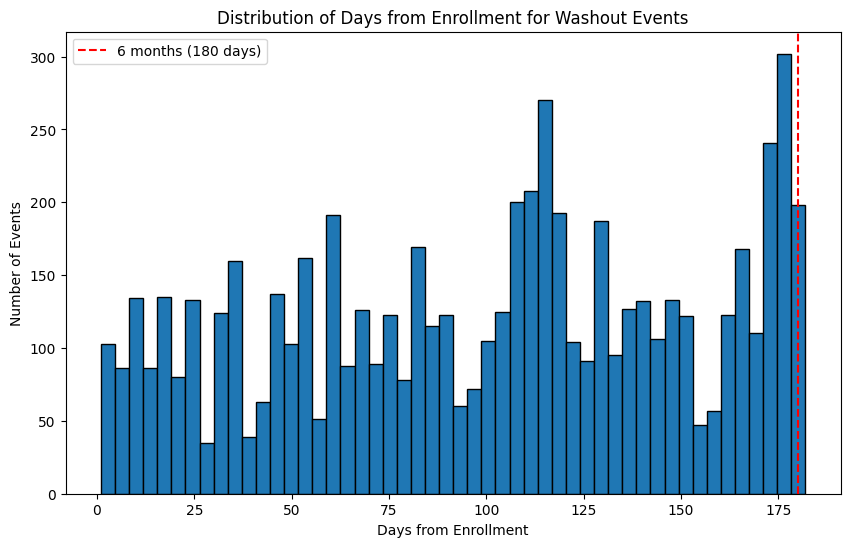


Statistics:
Min days: 1.0
Max days: 182.0
Mean days: 99.9
Median days: 108.0


In [17]:
# Check distribution of days from enrollment for washout events
import matplotlib.pyplot as plt

washout_days = washout_events['days_from_enroll'].dropna()
plt.figure(figsize=(10, 6))
plt.hist(washout_days, bins=50, edgecolor='black')
plt.xlabel('Days from Enrollment')
plt.ylabel('Number of Events')
plt.title('Distribution of Days from Enrollment for Washout Events')
plt.axvline(x=180, color='r', linestyle='--', label='6 months (180 days)')
plt.legend()
plt.show()

print(f"\nStatistics:")
print(f"Min days: {washout_days.min():.1f}")
print(f"Max days: {washout_days.max():.1f}")
print(f"Mean days: {washout_days.mean():.1f}")
print(f"Median days: {washout_days.median():.1f}")


In [16]:
# Compare E_original vs E_washout for a few example patients
print("Comparing E_original vs E_washout for sample patients...")
sample_patients = [0, 100, 500]  # First few patients

for patient_idx in sample_patients:
    if patient_idx >= E_test.shape[0]:
        continue
    
    eid = eid_order_test[patient_idx]
    original = E_test[patient_idx, :]
    washout = E_washout[patient_idx, :]
    
    n_changed = (original != washout).sum().item()
    if n_changed > 0:
        print(f"\nPatient {eid} (index {patient_idx}): {n_changed} diseases changed")
        changed_diseases = torch.where(original != washout)[0]
        for disease_idx in changed_diseases[:5]:  # Show first 5
            phecode = disease_codes[disease_idx] if disease_idx < len(disease_codes) else 'unknown'
            print(f"  Disease {phecode} (idx {disease_idx}): {original[disease_idx].item()} -> {washout[disease_idx].item()}")


Comparing E_original vs E_washout for sample patients...


## Detailed Comparison: Original E vs E_washout for All Censored Events


In [18]:
# Find all positions where E was changed
print("="*80)
print("DETAILED COMPARISON: ORIGINAL E vs E_WASHOUT")
print("="*80)

# Find all changed positions
changed_mask = (E_test != E_washout)
changed_positions = torch.nonzero(changed_mask, as_tuple=False)

print(f"\nTotal positions changed: {len(changed_positions):,}")

# Create a DataFrame with the changes
changes_data = []
for pos in changed_positions:
    patient_idx = pos[0].item()
    disease_idx = pos[1].item()
    
    eid = eid_order_test[patient_idx]
    phecode = disease_codes[disease_idx] if disease_idx < len(disease_codes) else 'unknown'
    
    original_value = E_test[patient_idx, disease_idx].item()
    washout_value = E_washout[patient_idx, disease_idx].item()
    
    # Convert time indices to ages
    original_age = original_value + 30  # min_age = 30
    washout_age = washout_value + 30
    
    # Get enrollment age for this patient
    enroll_age = enrollment_ages.get(eid, None)
    
    changes_data.append({
        'eid': eid,
        'patient_idx': patient_idx,
        'phecode': phecode,
        'disease_idx': disease_idx,
        'original_E': original_value,
        'washout_E': washout_value,
        'original_age': original_age,
        'washout_age': washout_age,
        'enroll_age': enroll_age,
        'age_diff': original_age - washout_age if enroll_age else None
    })

changes_df = pd.DataFrame(changes_data)

print(f"\nSummary of changes:")
print(f"  Mean original age: {changes_df['original_age'].mean():.1f} years")
print(f"  Mean washout age: {changes_df['washout_age'].mean():.1f} years")
print(f"  Mean age difference: {changes_df['age_diff'].mean():.1f} years")
print(f"  Min age difference: {changes_df['age_diff'].min():.1f} years")
print(f"  Max age difference: {changes_df['age_diff'].max():.1f} years")

print(f"\nFirst 20 changed positions:")
display(changes_df.head(20))


DETAILED COMPARISON: ORIGINAL E vs E_WASHOUT

Total positions changed: 1,087

Summary of changes:
  Mean original age: 59.6 years
  Mean washout age: 58.6 years
  Mean age difference: 1.0 years
  Min age difference: 1.0 years
  Max age difference: 1.0 years

First 20 changed positions:


,eid,patient_idx,phecode,disease_idx,original_E,washout_E,original_age,washout_age,enroll_age,age_diff
0,1000833,61,604.1,254,21,20,51,50,51,1
1,1001140,87,530.11,180,26,25,56,55,56,1
2,1001175,90,280.1,61,34,33,64,63,64,1
3,1001175,90,411.8,115,34,33,64,63,64,1
4,1001508,114,41.4,6,25,24,55,54,55,1
5,1001508,114,244.4,45,25,24,55,54,55,1
6,1001508,114,272.11,52,25,24,55,54,55,1
7,1001508,114,716.9,299,25,24,55,54,55,1
8,1001599,121,618.1,262,29,28,59,58,59,1
9,1001601,122,740.1,325,34,33,64,63,64,1


## Create Washout Matrices for 1, 3, and 6 Months


In [19]:
# Create washout matrices for 1, 3, and 6 months
print("="*80)
print("CREATING WASHOUT MATRICES FOR 1, 3, AND 6 MONTHS")
print("="*80)

washout_months_list = [1, 3, 6]
washout_matrices = {}
washout_stats = {}

for washout_months in washout_months_list:
    print(f"\n{'='*80}")
    print(f"Processing {washout_months}-month washout window...")
    print(f"{'='*80}")
    
    # Apply washout
    E_washout_current, hesin_annotated_current = apply_washout_to_E(
        hesin_df=hesin_test,
        icdlab_df=icdlab_test,
        bd_censor_df=bd_censor_test,
        enrollment_ages_dict=enrollment_ages_test,
        E_original=E_test,
        eid_order=eid_order_test,
        disease_mapping=disease_mapping,
        washout_months=washout_months,
        min_age=30
    )
    
    # Store the matrix
    washout_matrices[washout_months] = E_washout_current
    
    # Calculate statistics
    n_changed = (E_test != E_washout_current).sum().item()
    n_total = E_test.numel()
    n_washout_events = (hesin_annotated_current['in_washout'] == True).sum()
    
    washout_stats[washout_months] = {
        'n_changed': n_changed,
        'n_total': n_total,
        'pct_changed': 100 * n_changed / n_total,
        'n_washout_events': n_washout_events
    }
    
    print(f"\n{washout_months}-month washout summary:")
    print(f"  Events changed in E matrix: {n_changed:,} / {n_total:,} ({100*n_changed/n_total:.3f}%)")
    print(f"  Events in washout window: {n_washout_events:,}")

print(f"\n{'='*80}")
print("SUMMARY OF ALL WASHOUT WINDOWS")
print(f"{'='*80}")
print(f"{'Washout':<10} {'E Changed':<15} {'% Changed':<12} {'Washout Events':<15}")
print(f"{'-'*60}")
for months in washout_months_list:
    stats = washout_stats[months]
    print(f"{months} months   {stats['n_changed']:>8,}      {stats['pct_changed']:>6.3f}%      {stats['n_washout_events']:>10,}")


CREATING WASHOUT MATRICES FOR 1, 3, AND 6 MONTHS

Processing 1-month washout window...
APPLYING 1-MONTH WASHOUT WINDOW
Mapping 10,000 patients to E matrix rows

Preparing HESIN data...
Joining with bd.censor for enrollment dates...
Mapping ICD codes to Phecodes...
After Phecode mapping: 796,550 events with valid Phecodes
Found 819 / 796,550 events (0.10%) in washout window

Censoring events in washout window...

Censored 819 events in E matrix
Skipped 0 events (patient not in E matrix, missing data, or no disease mapping)

1-month washout summary:
  Events changed in E matrix: 197 / 3,480,000 (0.006%)
  Events in washout window: 819

Processing 3-month washout window...
APPLYING 3-MONTH WASHOUT WINDOW
Mapping 10,000 patients to E matrix rows

Preparing HESIN data...
Joining with bd.censor for enrollment dates...
Mapping ICD codes to Phecodes...
After Phecode mapping: 796,550 events with valid Phecodes
Found 2,733 / 796,550 events (0.34%) in washout window

Censoring events in washout w

In [ ]:
# Save the washout matrices
print("="*80)
print("SAVING WASHOUT MATRICES")
print("="*80)

import os
output_dir = "/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/washout"
os.makedirs(output_dir, exist_ok=True)

for washout_months in washout_months_list:
    output_path = os.path.join(output_dir, f"E_washout_{washout_months}month_batch_0_10000.pt")
    torch.save(washout_matrices[washout_months], output_path)
    print(f"Saved {washout_months}-month washout matrix to: {output_path}")
    print(f"  Shape: {washout_matrices[washout_months].shape}")
    print(f"  Events changed: {washout_stats[washout_months]['n_changed']:,}")

print(f"\nAll washout matrices saved to: {output_dir}")


In [20]:
%run /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/pythonscripts/evaluate_washout_predictions.py

EVALUATING WASHOUT PREDICTIONS: 1-YEAR AND 10-YEAR
Washout base directory: /Users/sarahurbut/Library/CloudStorage/Dropbox/washout_comparison_10k/
Washout versions: ['no_washout', '1month', '3month', '6month']
Output directory: /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/washout_evaluation
Subset size: 10000

Loading common data...

Subsetting to first 10000 patients...
After subsetting: Y: 10000, E: 10000, pce_df: 10000

PROCESSING WASHOUT VERSION: NO_WASHOUT
Loading pi tensor from: /Users/sarahurbut/Library/CloudStorage/Dropbox/washout_comparison_10k/no_washout/pi_washout_no_washout_0_10000.pt
Pi tensor shape: torch.Size([10000, 348, 52])

1-YEAR PREDICTIONS (offset=0)
Filtering for 1: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
-----------------

✓ Saved plot to: /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/washout_evaluation/washout_performance_plot.png
✓ Saved summary plot to: /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/washout_evaluation/washout_drop_summary.png

WASHOUT IMPACT SUMMARY

1-Year Predictions (No Washout → 6-Month Washout):
  Mean AUC drop: 0.0112
  Median AUC drop: 0.0026
  Max AUC drop: 0.0584 (Breast_Cancer)
  Min AUC drop: -0.0000 (Colorectal_Cancer)

10-Year Predictions (No Washout → 6-Month Washout):
  Mean AUC drop: 0.0010
  Median AUC drop: 0.0001
  Max AUC drop: 0.0066 (Breast_Cancer)
  Min AUC drop: 0.0000 (Stroke)

✓ All plots saved successfully!


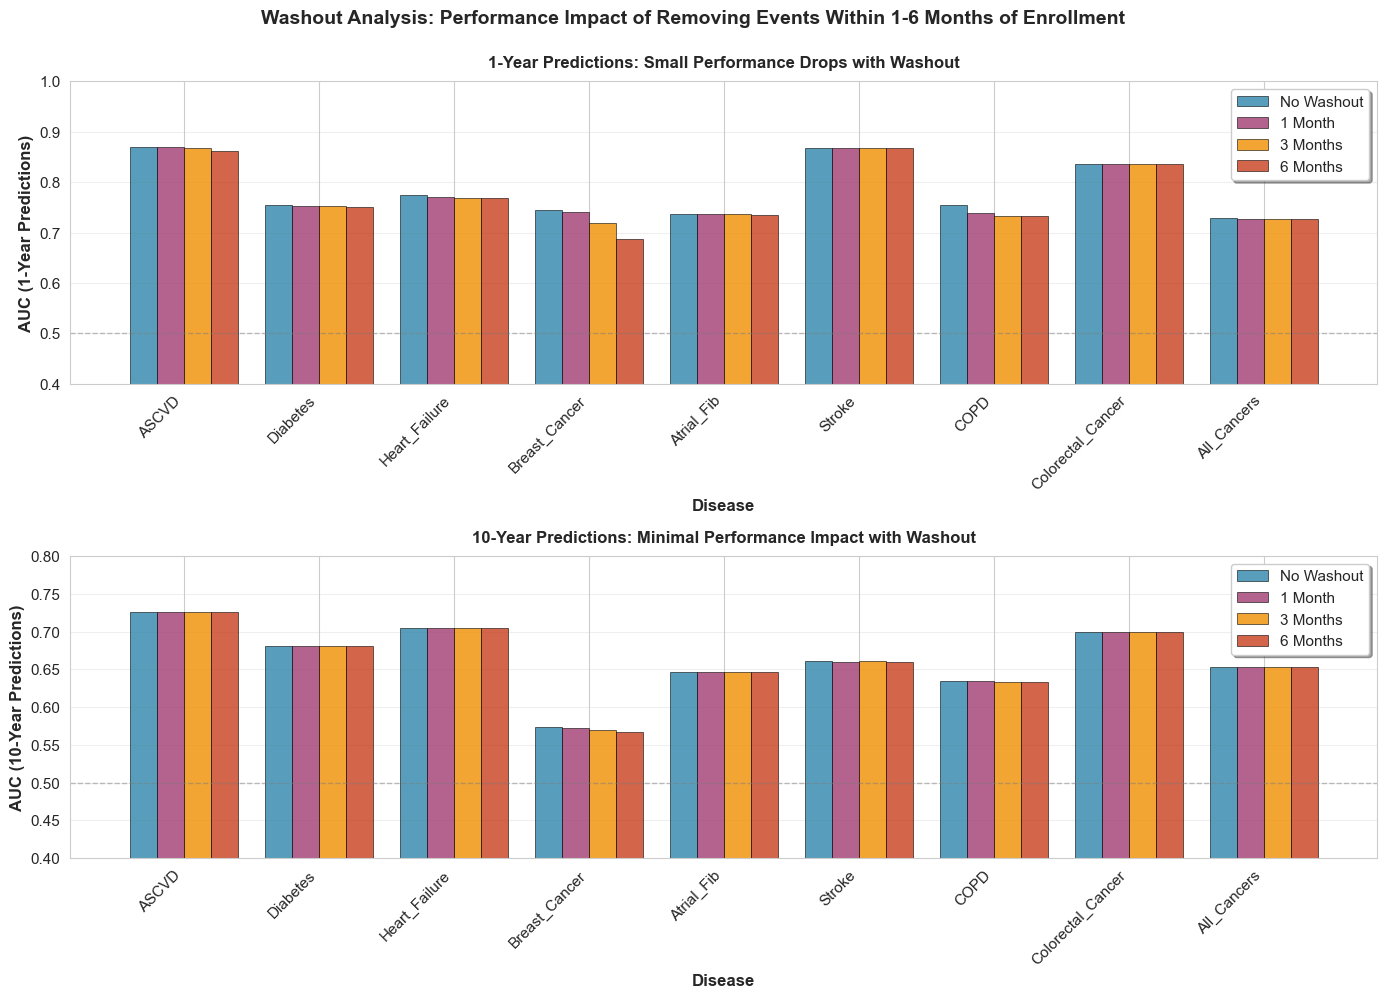

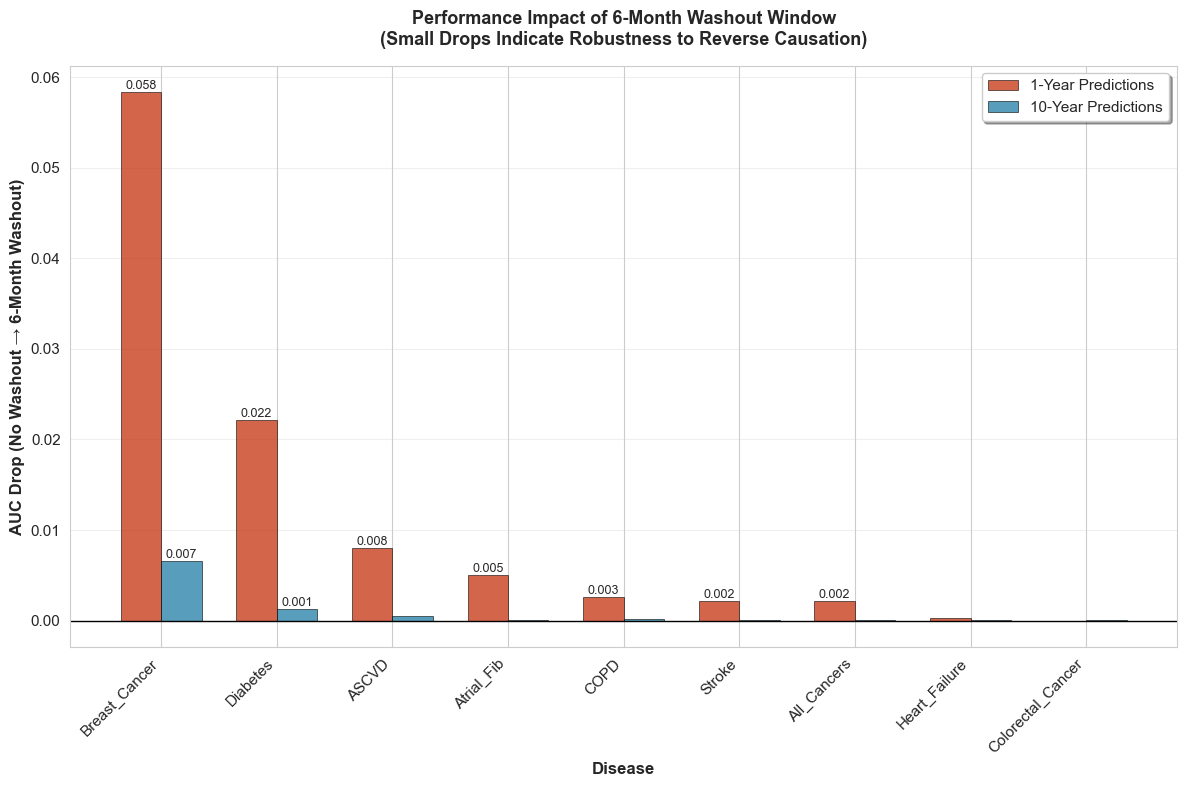

In [21]:
%run /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/pythonscripts/plot_washout_results.py

In [22]:
# Load E matrices for comparison
E_enrollment_full_path = "/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/E_enrollment_full.pt"
onemonthplan = '/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/washout/E_washout_1month_batch_0_10000.pt'
threemonthplan = '/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/washout/E_washout_3month_batch_0_10000.pt'
sixmonthplan = '/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/washout/E_washout_6month_batch_0_10000.pt'

print("Loading E matrices...")
E_full = torch.load(E_enrollment_full_path, weights_only=False)[:10000,:]
E_washout_1month = torch.load(onemonthplan, weights_only=False) 
E_washout_3month = torch.load(threemonthplan, weights_only=False) 
E_washout_6month = torch.load(sixmonthplan, weights_only=False)

print(f"✓ Loaded all E matrices")
print(f"  E_full shape: {E_full.shape}")
print(f"  E_washout_1month shape: {E_washout_1month.shape}")
print(f"  E_washout_3month shape: {E_washout_3month.shape}")
print(f"  E_washout_6month shape: {E_washout_6month.shape}")

# Quick comparison: count matches vs changes
print(f"\n{'='*80}")
print("QUICK COMPARISON: MATCHES vs CHANGES")
print(f"{'='*80}")

for period_name, E_washout in [('1-month', E_washout_1month), 
                                ('3-month', E_washout_3month), 
                                ('6-month', E_washout_6month)]:
    matches = (E_full == E_washout).sum().item()
    changes = (E_full != E_washout).sum().item()
    total = E_full.numel()
    pct_match = 100 * matches / total
    pct_change = 100 * changes / total
    
    print(f"\n{period_name} washout:")
    print(f"  Matches: {matches:,} / {total:,} ({pct_match:.3f}%)")
    print(f"  Changes: {changes:,} / {total:,} ({pct_change:.3f}%)")

print(f"\n{'='*80}")




Loading E matrices...
✓ Loaded all E matrices
  E_full shape: torch.Size([10000, 348])
  E_washout_1month shape: torch.Size([10000, 348])
  E_washout_3month shape: torch.Size([10000, 348])
  E_washout_6month shape: torch.Size([10000, 348])

QUICK COMPARISON: MATCHES vs CHANGES

1-month washout:
  Matches: 3,479,803 / 3,480,000 (99.994%)
  Changes: 197 / 3,480,000 (0.006%)

3-month washout:
  Matches: 3,479,418 / 3,480,000 (99.983%)
  Changes: 582 / 3,480,000 (0.017%)

6-month washout:
  Matches: 3,478,913 / 3,480,000 (99.969%)
  Changes: 1,087 / 3,480,000 (0.031%)



In [ ]:
%run /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/pythonscripts/evaluate_1_2_3yr_washout.py

✓ Saved plot to /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/washout_evaluation/plots/comprehensive_washout_comparison_1yr_10yr.png
✓ Saved line plot to /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/washout_evaluation/plots/comprehensive_washout_comparison_line_plot.png


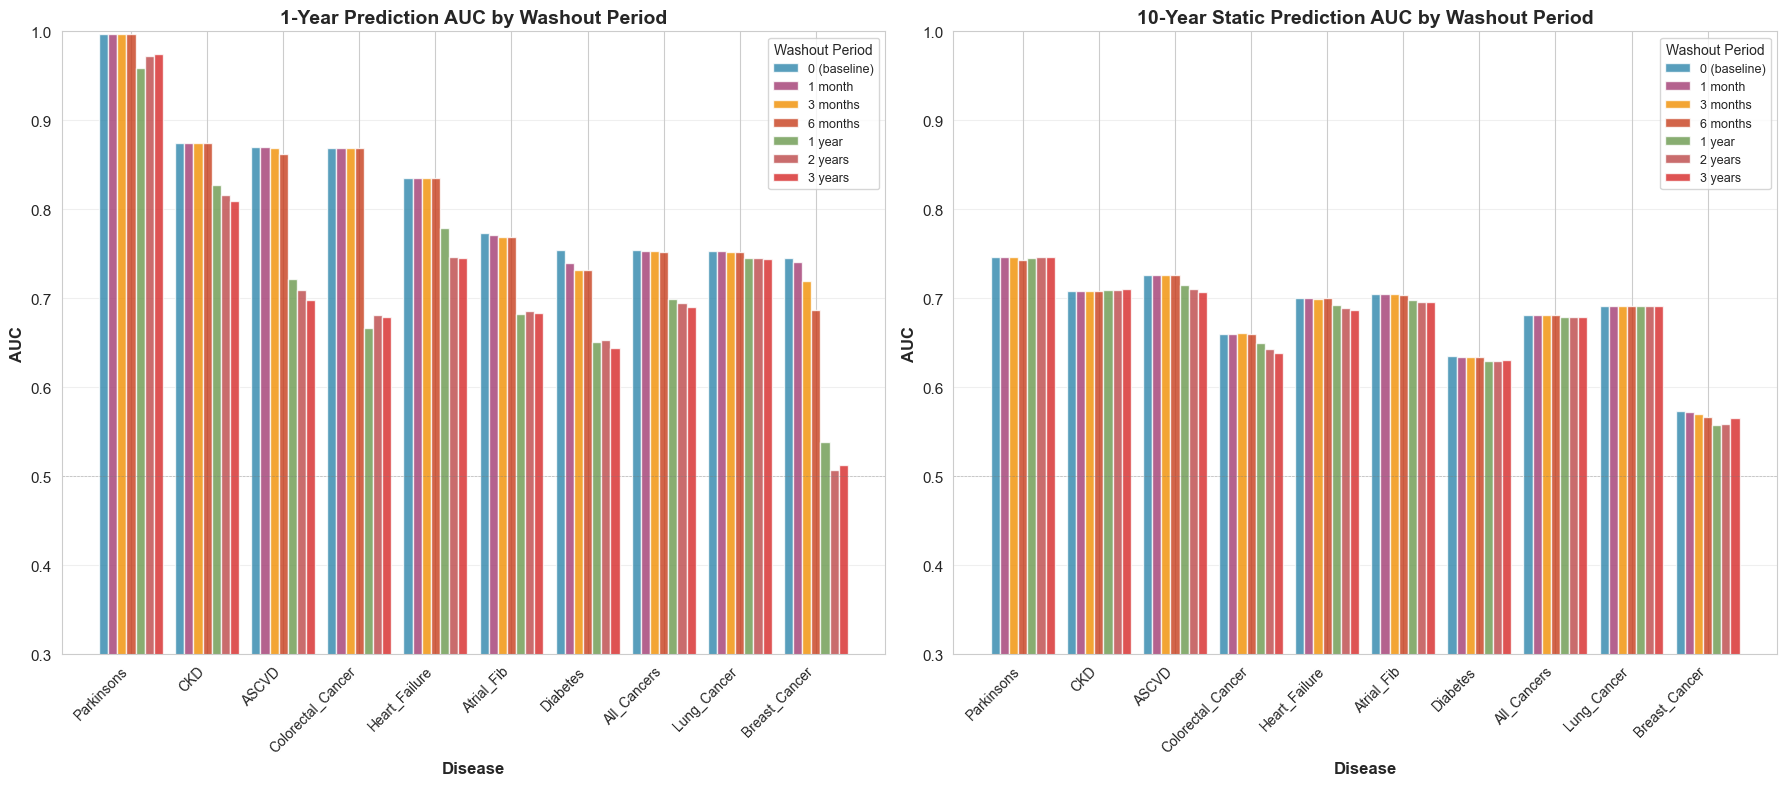

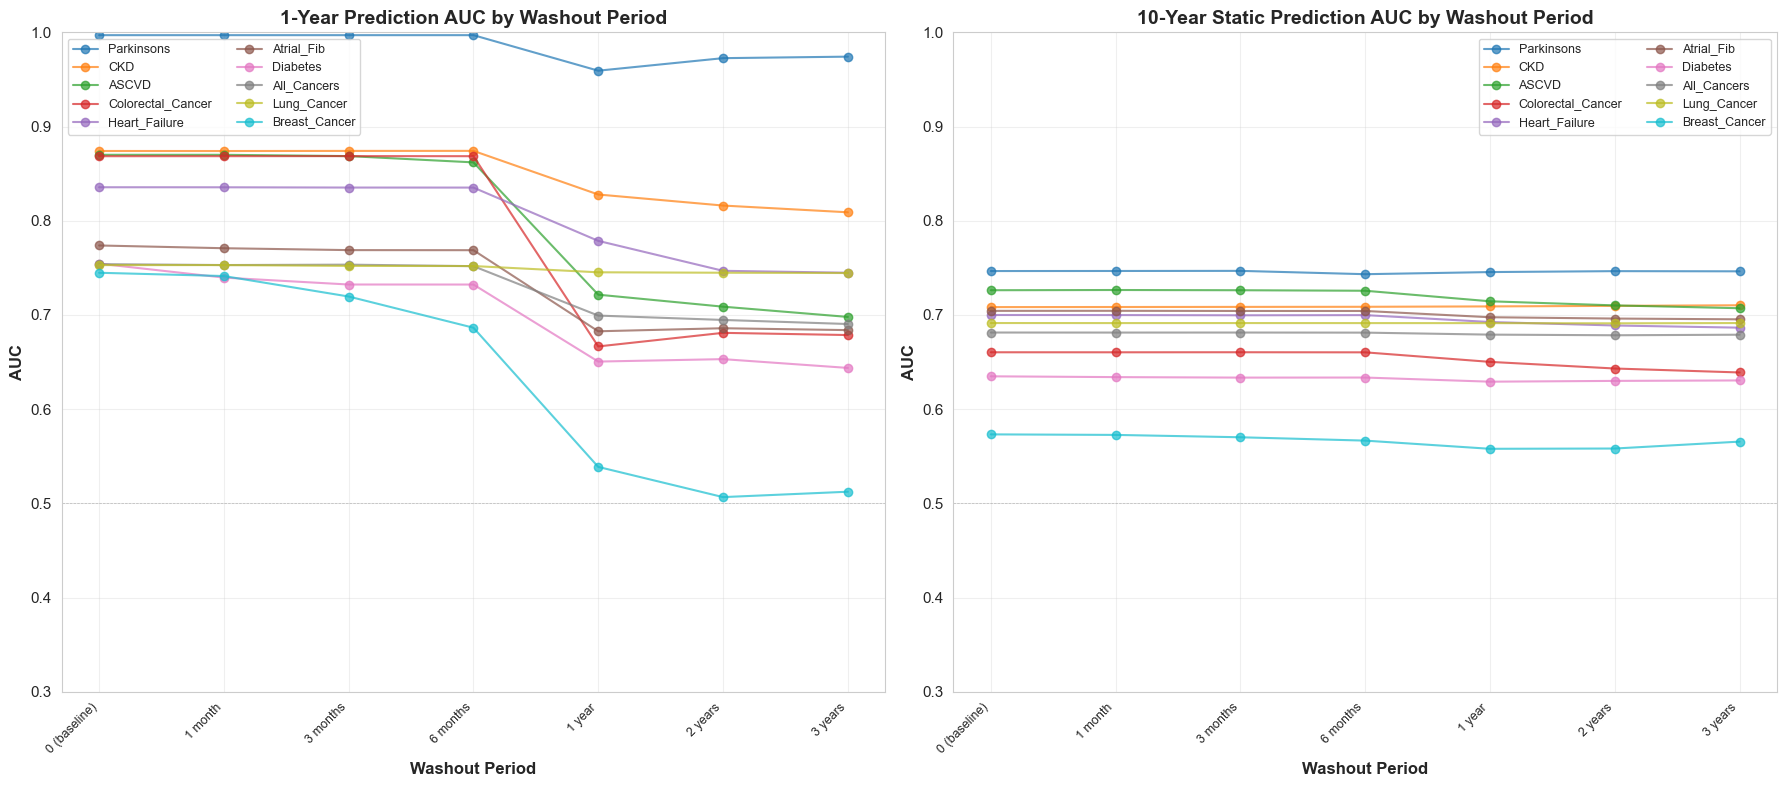


✓ Comparison plots created successfully!
  Bar plot: /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/washout_evaluation/plots/comprehensive_washout_comparison_1yr_10yr.png
  Line plot: /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/washout_evaluation/plots/comprehensive_washout_comparison_line_plot.png


In [23]:
%run /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/pythonscripts/plot_comprehensive_washout_comparison.py

In [ ]:
%run /Users/sarahurbut/aladynoulli2/claudefile/compare_loop_vs_vectorized.py